# Debug $\Delta \phi$ for $H \rightarrow \tau^- \tau^+$

The idea is that if $n=1$ that the angle not well defined and root does some weird stuff and just takes the peak values.

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np")
    return data

In [3]:
#data = load_data("./../src/tree.root")
path = "/afs/cern.ch/work/s/saaumill/public/final-fullsim-inputNN"
data = load_data(f"{path}/Htautau-inputNN-debug-relphi_parent_info_correct.root")

In [4]:
data.keys()

dict_keys(['event_number', 'n_hit', 'n_part', 'jet_p', 'jet_e', 'jet_mass', 'jet_nconst', 'jet_npfcand', 'jet_theta', 'jet_phi', 'recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'pfcand_e', 'pfcand_p', 'pfcand_theta', 'pfcand_phi', 'pfcand_type', 'pfcand_charge', 'pfcand_isEl', 'pfcand_isMu', 'pfcand_isGamma', 'pfcand_isNeutralHad', 'pfcand_isChargedHad', 'jet_nmu', 'jet_nel', 'jet_ngamma', 'jet_nnhad', 'jet_nchad', 'pfcand_erel_log', 'pfcand_phirel', 'pfcand_thetarel', 'pfcand_dptdpt', 'pfcand_detadeta', 'pfcand_dphidphi', 'pfcand_dxydxy', 'pfcand_dzdz', 'pfcand_dxydz', 'pfcand_dphidxy', 'pfcand_dlambdadz', 'pfcand_dxyc', 'pfcand_dxyctgtheta', 'pfcand_phic', 'pfcand_phidz', 'pfcand_phictgtheta', 'pfcand_cdz', 'pfcand_cctgtheta', 'pfcand_dxy', 'pfcand_dz', 'pfcand_btagSip2dVal', 'pfcand_btagSip2dSig', 'pfcand_btagSip3dVal', 'pfcand_btagSip3dSig', 'pfcand_btagJetDistVal', 'pfcand_btagJetDistSig', 'pfcand_mtof', 'pfcand_dndx', 'pf

In [5]:
n_const = data['jet_nconst']

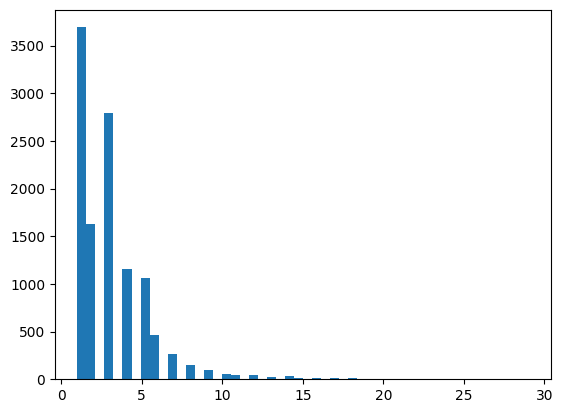

In [6]:
plt.hist(n_const, bins=50)
plt.show()

In [7]:
i_n1 = np.where(n_const == 1)
i_n1

(array([    2,     5,     7, ..., 11588, 11589, 11590]),)

In [8]:
rel_phi = data['pfcand_phirel']
rel_phi_n1 = rel_phi[i_n1]

In [9]:
rel_phi_n1

array([array([0.24497867], dtype=float32),
       array([-2.3561945], dtype=float32),
       array([1.5707964], dtype=float32), ...,
       array([2.1870933], dtype=float32),
       array([1.2490457], dtype=float32),
       array([-2.0344439], dtype=float32)], dtype=object)

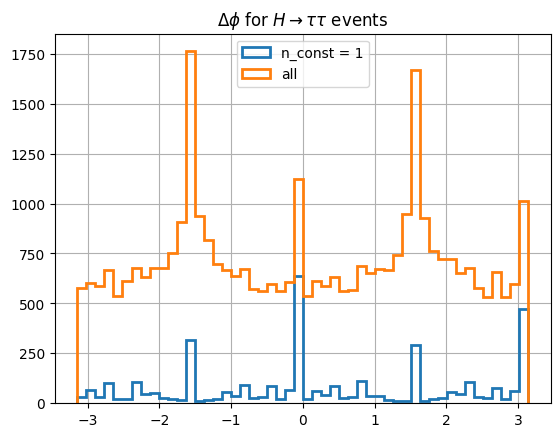

In [10]:
plt.hist(np.concatenate(rel_phi_n1), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 1")
plt.hist(np.concatenate(rel_phi), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="all")
plt.grid()
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events")
plt.show()

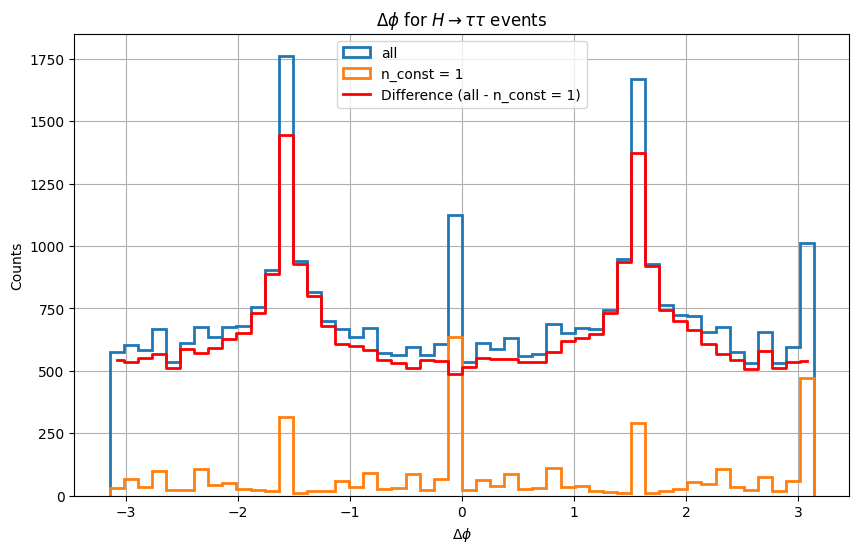

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
# rel_phi and rel_phi_n1 should be provided as lists or arrays of the same length

# Compute histograms
bins = 50
range_bins = (-np.pi, np.pi)

# Compute histograms
hist_all, bin_edges_all = np.histogram(np.concatenate(rel_phi), bins=bins, range=range_bins)
hist_n1, bin_edges_n1 = np.histogram(np.concatenate(rel_phi_n1), bins=bins, range=range_bins)

# Compute the bin centers
bin_centers = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2

# Compute the difference between histograms
hist_diff = hist_all - hist_n1

# Plot the histograms
plt.figure(figsize=(10, 6))

plt.hist(np.concatenate(rel_phi), bins=bins, histtype='step', linewidth=2.0, range=range_bins, label="all")
plt.hist(np.concatenate(rel_phi_n1), bins=bins, histtype='step', linewidth=2.0, range=range_bins, label="n_const = 1")

# Plot the difference histogram
plt.step(bin_centers, hist_diff, where='mid', linewidth=2.0, label="Difference (all - n_const = 1)", color='red')

plt.grid()
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events")
plt.xlabel(r"$\Delta \phi$")
plt.ylabel("Counts")
plt.show()


Ok nice!!!! I can now explain the peaks at 0 and pi but not the once at $\pm \frac{\pi}{2}$. 

New idea: the peaks for charged constituents at pi/2 are due to misclassification to neutral particles. (looking at plot) Ok, shame this is not the explanation. I hoped that the peak at $\pm \frac{\pi}{2}$ might actually be neutral particles that are misidentified but they are not. 

But what about photons?

In [12]:
def get_index_charged_particles(process, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    types = process['pfcand_type']
    if ptype=='cpart':
        num = [-211, -13, -11, 11, 13, 211] 
    elif ptype=='npart':
        num = [2112]
    elif ptype=='photon':
        num = [22]
    elif ptype=='electron':
        num = [11, -11]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [13]:
def get_value_highest_energy_particle(process, k=3, ptype='cpart'):
    """return the index of the k highest energy charged particle in each event"""
    particles_e = process['pfcand_e']
    mask_chad = get_index_charged_particles(process, ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
    return index_charged

In [14]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [15]:
index = get_value_highest_energy_particle(process=data, ptype="photon", k=3)
pid_MC = get_chad_elements(data["pfcand_MCPID"], index)
pid_reco = get_chad_elements(data["pfcand_type"], index)
relphi = get_chad_elements(data["pfcand_phirel"], index)
parent_id = get_chad_elements(data["pfcand_parent_ID"], index)


In [16]:
len(np.concatenate(data["pfcand_parent_ID"]))

36010

In [17]:
len(np.concatenate(data["pfcand_phirel"]))

36010

In [18]:
len(pid_MC[0])

6772

In [19]:
len(pid_reco[0])

6772

5192


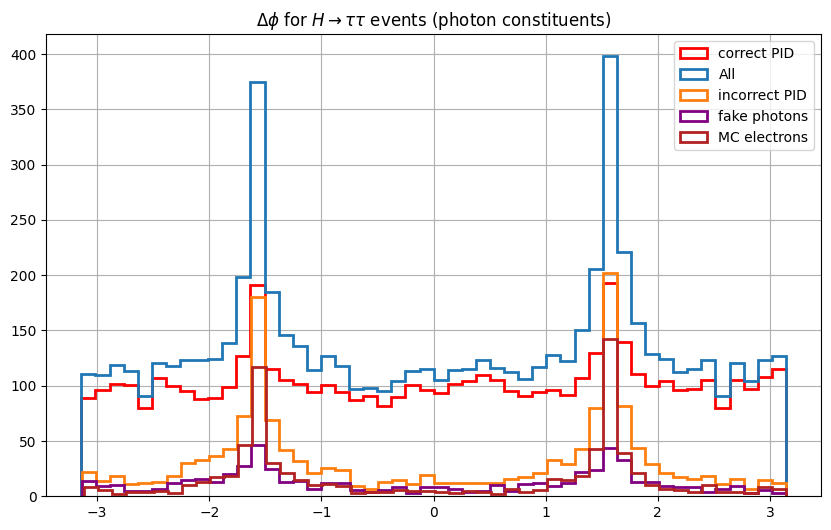

In [20]:
plt.figure(figsize=(10, 6))

ind_corr = np.where(pid_MC[0] == pid_reco[0])
ind_incorr = np.where(pid_MC[0] != pid_reco[0])
ind_noMC = np.where(pid_MC[0] == -999)
ind_fake_e = np.where(abs(pid_MC[0]) == 11)
print(len(ind_corr[0]))

plt.hist(relphi[0][ind_corr], bins=50, histtype='step', linewidth=2.0, density=False, label="correct PID", color='red')
plt.hist(relphi[0], bins=50, histtype='step', linewidth=2.0, density=False, label="All")
plt.hist(relphi[0][ind_incorr], bins=50, histtype='step', linewidth=2.0, density=False, label="incorrect PID")
plt.hist(relphi[0][ind_noMC], bins=50, histtype='step', linewidth=2.0, density=False, label="fake photons", color='purple')
plt.hist(relphi[0][ind_fake_e], bins=50, histtype='step', linewidth=2.0, density=False, label="MC electrons", color='firebrick')
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (photon constituents)")
plt.grid()
plt.show()

Ok so this is not the answer i was looking for? The distribution looks more similar to other decay channels for photons without the incorrect identified particles. But what are they? We see that it's not about the fake photons, electrons yes, but why electrons?? And why do these electrons do to produce the peaks?

In [21]:
pid_MC[0]

array([ 22,  22,  11, ...,  22, -11,  22], dtype=int32)

In [22]:
pid_reco[0][ind_incorr]

array([22, 22, 22, ..., 22, 22, 22], dtype=int32)

In [23]:
which_instead, n_which_instead = np.unique(pid_MC[0][ind_incorr], return_counts=True)

In [24]:
for n, w in enumerate(which_instead):
    print(f"MC PID {w} \t: {n_which_instead[n]}")

MC PID -999 	: 606
MC PID -321 	: 2
MC PID -211 	: 82
MC PID -13 	: 11
MC PID -11 	: 370
MC PID 11 	: 398
MC PID 13 	: 16
MC PID 130 	: 14
MC PID 211 	: 68
MC PID 310 	: 1
MC PID 321 	: 3
MC PID 2212 	: 8
MC PID 1000010020 	: 1


In [28]:
# what are the parents of the miss-identified photons (MC electrons)?
print("parent PID of miss-identified photons which are MC electrons:")
parent_ids, ids_counts = np.unique(parent_id[0][ind_fake_e], return_counts=True)
for n, w in enumerate(parent_ids):
    print(f"Parent ID {w} \t: {ids_counts[n]}")


parent PID of miss-identified photons which are MC electrons:
Parent ID -211 	: 1
Parent ID -15 	: 169
Parent ID -13 	: 1
Parent ID 15 	: 186
Parent ID 22 	: 400
Parent ID 111 	: 10
Parent ID 211 	: 1


In [ ]:
# NEXT TASK:
# group into 3 classes: partents is photon/ tau/ other
# plot the delta phi for the 3 classes